# Base model choices

Yangkang Chen<br>
Sep 20, 2023

In [1]:
import pandas as pd
import numpy as np
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib
import warnings
import pickle
import os
import time

# matplotlib.style.use('ggplot')
# plt.rcParams['axes.facecolor']='w'
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
# Please download the sample data from:
# https://figshare.com/articles/dataset/Sample_data_Mallard_csv/24080745
# Assuming now it's downloaded and saved as './Sample_data_Mallard.csv'

# you can also try other species like 
# https://figshare.com/articles/dataset/Sample_data_Alder_Flycatcher_csv/24080751
# https://figshare.com/articles/dataset/Sample_data_Short-eared_Owl_csv/24080742
# https://figshare.com/articles/dataset/Sample_data_Eurasian_Tree_Sparrow_csv/24080748


In [4]:
data = pd.read_csv(f'./Sample_data_Mallard.csv')
data = data.drop('sampling_event_identifier', axis=1)

In [5]:
# data = data.sample(frac=0.1, replace=False)

In [6]:
def get_X_and_y(data):
    X = data.drop('count', axis=1)
    y = data['count'].values
    return X, y

X, y = get_X_and_y(data)

In [19]:
from stemflow.model.AdaSTEM import AdaSTEM, AdaSTEMClassifier, AdaSTEMRegressor
from stemflow.model.Hurdle import Hurdle_for_AdaSTEM, Hurdle
from stemflow.model_selection import ST_CV

from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor



In [38]:
base_model_dict = {
    'DecisionTree':{
        'classifier': DecisionTreeClassifier(random_state=42),
        'regressor': DecisionTreeRegressor(random_state=42)
    },
    'LightGBM':{
        'classifier': LGBMClassifier(n_jobs = 1, silent=True, random_state=42),
        'regressor': LGBMRegressor(n_jobs = 1, silent=True, random_state=42)
    },
    'XGBoost':{
        'classifier': XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
        'regressor': XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1)
    },
    # 'Ridge':{
    #     'classifier': Ridge(random_state=42),
    #     'regressor': RidgeClassifier(random_state=42)
    # }
}


In [32]:
# import signal

# class TimeoutException(Exception):   # Custom exception class
#     pass

# def timeout_handler(signum, frame):   # Custom signal handler
#     raise TimeoutException

# # Change the behavior of SIGALRM
# signal.signal(signal.SIGALRM, timeout_handler)


<function __main__.timeout_handler(signum, frame)>

In [39]:
all_metric_list = []

for base_model_name in base_model_dict.keys():
    print(f'Training {base_model_name}')
    
    metrics_for_base_model = []
    
    # First thing first: Spatio-temporal train test split
    CV_generator = ST_CV(X, y,
                            Spatio_blocks_count = 50, Temporal_blocks_count=50,
                            CV=5)

    continue_training = True
    for cv_count, (X_train, X_test, y_train, y_test) in enumerate(CV_generator):
        
        if not continue_training:
            break
        
        # 1. Train AdaSTEM hurdle model
        model = AdaSTEMRegressor(
            base_model=Hurdle(
                classifier=base_model_dict[base_model_name]['classifier'],
                regressor=base_model_dict[base_model_name]['regressor']
            ),
            save_gridding_plot = True,
            ensemble_fold=10, 
            min_ensemble_required=7,
            grid_len_lon_upper_threshold=25,
            grid_len_lon_lower_threshold=5,
            grid_len_lat_upper_threshold=25,
            grid_len_lat_lower_threshold=5,
            points_lower_threshold=50,
            Spatio1='longitude',
            Spatio2 = 'latitude', 
            Temporal1 = 'DOY',
            use_temporal_to_train=True,
            njobs=1                       
        )
        
        start_t = time.time()
        ## fit adastem
        
        # signal.alarm(1800)
        # try:
        model.fit(X_train.reset_index(drop=True), y_train, verbosity=0)
        # except TimeoutException:
        #     print('Time out')
        #     continue
        # else:
        #     signal.alarm(0)
            
        end_t = time.time()
        training_time = end_t - start_t
        
        if training_time>1800:
            continue_training = False
            break
        
        # Evaluation
        start_t = time.time()
        pred_adastem = model.predict(X_test, verbosity=0)
        end_t = time.time()
        prediction_time = end_t - start_t
        
        perc = np.sum(np.isnan(pred_adastem.flatten()))/len(pred_adastem.flatten())
        print(f'Model {base_model_name}, CV {cv_count}: AdaSTEM percentage not predictable {round(perc*100, 2)}%')

        # 3. save metrics
        pred_df = pd.DataFrame({
            'y_true':y_test.flatten(),
            'y_pred_adastem':np.where(pred_adastem.flatten()<0, 0, pred_adastem.flatten()),
        }).dropna() # to make sure that all points are both predicatble by adastem and simple hurdle model
        
        ## 3.1 adastem metrics
        metric_dict = AdaSTEM.eval_STEM_res('hurdle', pred_df.y_true, pred_df.y_pred_adastem)
        metric_dict['X_train_size'] = X_train.shape[0]
        metric_dict['CV'] = cv_count
        metric_dict['perc_not_predictable'] = perc
        metric_dict['model'] = base_model_name
        metric_dict['Training_time'] = training_time
        metric_dict['Prediction_time'] = prediction_time
        metrics_for_base_model.append(metric_dict.copy())
        print(metric_dict)
        print()
        
    if not continue_training:
        continue
    
    metrics_for_base_model = pd.DataFrame(metrics_for_base_model)
    metrics_for_base_model.to_csv(f'./Base_model_choices_metrics_{base_model_name}.csv', index=False)
    
    all_metric_list.append(metrics_for_base_model)
        
    
    

Training DecisionTree
Model DecisionTree, CV 0: AdaSTEM percentage not predictable 3.07%
{'AUC': 0.6769272134849056, 'kappa': 0.16475351574062091, 'f1': 0.3953695988572789, 'precision': 0.24830860090457146, 'recall': 0.969639468690702, 'average_precision': 0.2460345097293022, 'Spearman_r': 0.39503080745079516, 'Pearson_r': 0.20558452868412916, 'R2': -0.14025426215117354, 'MAE': 5.695269288713106, 'MSE': 1869.304099179213, 'poisson_deviance_explained': 0.20362568450861718, 'X_train_size': 318477, 'CV': 0, 'perc_not_predictable': 0.030739791224562392, 'model': 'DecisionTree', 'Training_time': 638.3415200710297, 'Prediction_time': 36.68179988861084}

Model DecisionTree, CV 1: AdaSTEM percentage not predictable 3.44%
{'AUC': 0.677097274188433, 'kappa': 0.16451919881875032, 'f1': 0.3946200205791563, 'precision': 0.24770709922678033, 'recall': 0.9697998699515931, 'average_precision': 0.2454472663770533, 'Spearman_r': 0.3982500674280532, 'Pearson_r': 0.0844851585574298, 'R2': -0.0454252265281

In [40]:
all_metric_df = pd.concat(all_metric_list, axis=0).reset_index(drop=False)
all_metric_df.to_csv('./Base_model_choices_metrics_all.csv',index=False)


In [44]:
all_metric_df

Index(['index', 'AUC', 'kappa', 'f1', 'precision', 'recall',
       'average_precision', 'Spearman_r', 'Pearson_r', 'R2', 'MAE', 'MSE',
       'poisson_deviance_explained', 'X_train_size', 'CV',
       'perc_not_predictable', 'model', 'Training_time', 'Prediction_time'],
      dtype='object')

In [47]:
new_all_metric_df = []
for index,line in all_metric_df.iterrows():
    for me in ['AUC', 'kappa', 'f1', 'precision', 'recall',
       'average_precision', 'Spearman_r', 'Pearson_r', 'R2', 'MAE', 'MSE']:
        new_all_metric_df.append({
            'model':line['model'],
            'CV':line['CV'],
            'Training_time':line['Training_time'],
            'Prediction_time':line['Prediction_time'],
            'perc_not_predictable':line['perc_not_predictable'],
            'X_train_size':line['X_train_size'],
            'metric_name':me,
            'value':line[me]
        })
new_all_metric_df = pd.DataFrame(new_all_metric_df)

In [48]:
new_all_metric_df

,model,CV,Training_time,Prediction_time,perc_not_predictable,X_train_size,metric_name,value
0,DecisionTree,0,638.341520,36.681800,0.030740,318477,AUC,0.676927
1,DecisionTree,0,638.341520,36.681800,0.030740,318477,kappa,0.164754
2,DecisionTree,0,638.341520,36.681800,0.030740,318477,f1,0.395370
3,DecisionTree,0,638.341520,36.681800,0.030740,318477,precision,0.248309
4,DecisionTree,0,638.341520,36.681800,0.030740,318477,recall,0.969639
...,...,...,...,...,...,...,...,...
160,XGBoost,4,1699.657751,57.689154,0.033501,316987,Spearman_r,0.470334
161,XGBoost,4,1699.657751,57.689154,0.033501,316987,Pearson_r,0.190081
162,XGBoost,4,1699.657751,57.689154,0.033501,316987,R2,-0.315057
163,XGBoost,4,1699.657751,57.689154,0.033501,316987,MAE,4.229131


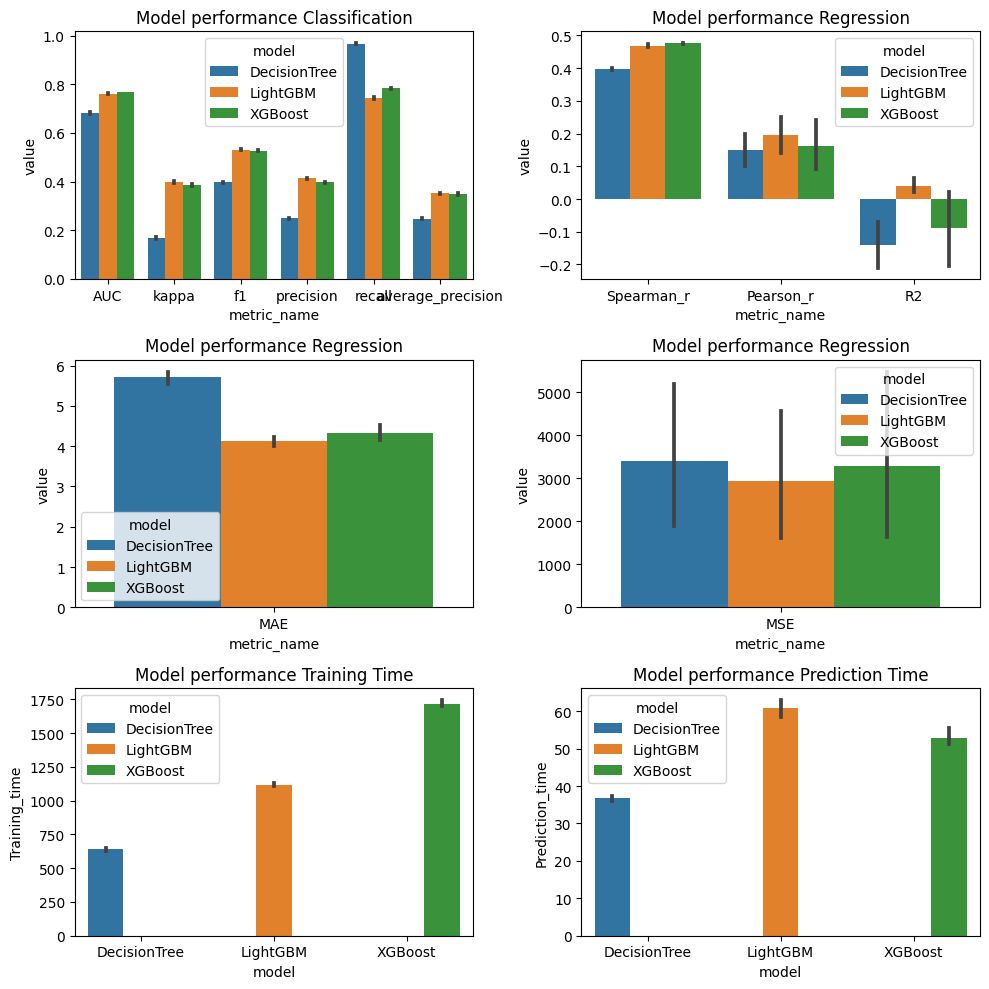

In [76]:
import seaborn as sns
dat_for_plot = new_all_metric_df

# plot
fig, ax = plt.subplots(3, 2, figsize=(10,10), gridspec_kw={'width_ratios': [2, 2]})

### classification
plt.sca(ax[0,0])
sns.barplot(data=dat_for_plot[
        dat_for_plot.metric_name.isin(['AUC', 'kappa', 'f1', 'precision', 'recall', 'average_precision'])
    ], ci=95, 
            x="metric_name", y="value", hue="model")
plt.title('Model performance Classification')

## reg
plt.sca(ax[0,1])
sns.barplot(data=dat_for_plot[
        dat_for_plot.metric_name.isin(['Spearman_r', 'Pearson_r', 'R2', 'poisson_deviance_explained'])
    ], ci=95, 
            x="metric_name", y="value", hue="model")
plt.title('Model performance Regression')

## reg
plt.sca(ax[1,0])
sns.barplot(data=dat_for_plot[
        dat_for_plot.metric_name.isin(['MAE'])
    ], ci=95, 
            x="metric_name", y="value", hue="model")
plt.title('Model performance Regression')


## reg
plt.sca(ax[1,1])
sns.barplot(data=dat_for_plot[
        dat_for_plot.metric_name.isin(['MSE'])
    ], ci=95, 
            x="metric_name", y="value", hue="model")
plt.title('Model performance Regression')
# plt.legend(bbox_to_anchor=(1,1))

plt.tight_layout()



## reg
plt.sca(ax[2,0])
sns.barplot(data=dat_for_plot.drop_duplicates('Training_time'), ci=95, 
            x='model',y="Training_time", hue="model")
plt.title('Model performance Training Time')


## reg
plt.sca(ax[2,1])
sns.barplot(data=dat_for_plot.drop_duplicates('Prediction_time'), ci=95, 
            x='model',y="Prediction_time", hue="model")
plt.title('Model performance Prediction Time')

plt.tight_layout()
plt.show()





In [77]:
from watermark import watermark
print(watermark())
print(watermark(packages="stemflow,numpy,scipy,pandas,xgboost,tqdm,matplotlib,h3pandas,geopandas,scikit-learn"))


Last updated: 2023-09-19T21:10:22.185848+08:00

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.14.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

stemflow    : 0.0.24
numpy       : 1.24.3
scipy       : 1.10.1
pandas      : 2.0.3
xgboost     : 1.7.6
tqdm        : 4.65.0
matplotlib  : 3.7.1
h3pandas    : 0.2.4
geopandas   : 0.11.1
scikit-learn: 0.0

